#### Task 2 : Design a classification system using Neural Networks - CNN, LSTM' s, etc - whichever you feel is relevant. *

### Importing Libraries

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords 
from nltk.tokenize import sent_tokenize, word_tokenize
import random
import pandas as pd
import re
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn_crfsuite import metrics
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras.layers import Bidirectional, Concatenate, Dot, Input, LSTM, Dropout
from keras.layers import RepeatVector, Dense, Activation, BatchNormalization
from sklearn.feature_extraction.text import TfidfVectorizer

### Step 1 : Loading and Reading data

In [57]:
# Reading the training data
train_df = pd.read_csv('/Users/aasthatandon/jigsaw-toxic-comment-classification-challenge/train.csv')

In [58]:
# Displaying top rows of the training dataset
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [59]:
# Reading test data and labels to be utilized later for evaluation
test_df = pd.read_csv('/Users/aasthatandon/jigsaw-toxic-comment-classification-challenge/test.csv')
test_label = pd.read_csv('/Users/aasthatandon/jigsaw-toxic-comment-classification-challenge/test_labels.csv')

# Concatenating test data and their corresponding labels in a single dataframe test_df
test_df = pd.concat([test_df,test_label],axis=1)
test_df.head() #Displaying top rows of the test dataset

test_data = test_df[test_df['toxic'] != -1] # removing rows with -1 values in toxic column
test_data = test_data.reset_index(drop=True) # resetting the index after deletion
test_data.describe()# this is just to checking minimum value,conclusion below

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,63978.000000,63978.000000,63978.000000,63978.000000,63978.000000,63978.000000
mean,0.095189,0.005736,0.057692,0.003298,0.053565,0.011129
std,0.293478,0.075522,0.233161,0.057334,0.225160,0.104905
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Already explained in Task 1 written below for reference.

Although ```describe()``` is not ideal for categorical variables, after removing -1 from the "toxic" column, checking the minimum values reveals that they are now 0 instead of -1. This suggests successful removal of all -1 instances, further supported by their likely mutual exclusivity in the column.

### Step 2 : Exploratory data analysis

Following things have been done in Task 1, hence not repeating here :

- Checking for Missing values
- Checking for -1 values in each label  for training dataset.
- Histogram plot for length of each comment
- Distribution of class labels 
- Word Cloud for most frequent words in each class

### Step 3 : Data Preparation

In [60]:
# stop words and stemmer
stop = stopwords.words('english')
stemmer = PorterStemmer()


# text preprocessing 
def document_tokenizer(doc):
    """
    given a sentence it converts
    it into words after cleaning
    """
    
    # tokenizing sentence to words,removing stop words and considering only letter words
    lowercase = [i.lower() for i in nltk.word_tokenize(doc) \
               if i.lower() not in stop and i.isalpha()] 
        
    ''' removing words containing consecutively 3 or more repeated letters, 
    such as 'heyyyyyy', 'hmmmmmmmmmm', or 'ohhh' '''
    repeat = []
    for word in lowercase:
        if re.findall('(\w)\\1{3,}', word) != []:
            repeat.append(word)
    
    lowercase = [word for word in lowercase if word not in repeat]
    
    # appying stemming after above cleaning
    normalized = [stemmer.stem(i) for i in lowercase] # stem the each words
    
    '''only considering words whose length is greater than 2 because 
    generally 2 letter words like "to","so" etc doesnot convey anything meaningful'''
    words = [word for word in normalized if len(word) > 2]
    return words


In [62]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and validation sets
train_data, valid_data = train_test_split(df, test_size=0.2, random_state=42)
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

# Printing the sizes of the training and validation datasets
print("Training data size:", len(train_data))
print("Validation data size:", len(valid_data))


Training data size: 127656
Validation data size: 31915


The ```read_glove_vecs``` function reads a GloVe word embedding file ```'glove.6B.50d.txt'``` which has  6 billion words and 50-dimensional embedding vector for each word. We are using glove.6B.50d.txt" because of its general-purpose nature,light-weight, balanced dimensionality, and widespread adoption.

This function returns ```word-to-index``` and ```index-to-word``` mappings, and returns a dictionary containing ```word-to-vector``` mappings.

In [64]:
def read_glove_vecs(glove_file):
    """
    Reads a GloVe word embedding file and processes it.
    
    Parameters:
    glove_file (str): Path to the GloVe file.
    
    Returns:
    words_to_index (dict): Dictionary mapping words to indices.
    index_to_words (dict): Dictionary mapping indices to words.
    word_to_vec_map (dict): Dictionary mapping words to their vector representations.
    """
    
    # Opening the GloVe file
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        
        # Processing each line in the file
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        
        # Creating word-to-index and index-to-word mappings
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    
    return words_to_index, index_to_words, word_to_vec_map

# Reading the GloVe vectors from 'glove.6B.50d.txt'
words_to_index, index_to_words, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')


In [66]:
# obtaining sentence embedding
def sentences_to_embedding(X, word_to_vec_map, max_len, embedding_length=50): # (m, maxLen, 50)
    """
    Converts an array of sentences (strings) into an array of word embedding vectors corresponding to words in the sentences.
    
    args:
        X: array of sentences (strings), of shape (m, 1)
        word_to_vec_map: a dictionary containing the each word mapped to its embedding vector
        max_len: maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
        embedding_length: 50 in this case when using glove.6B.50d.txt
    
    return:
    data_array: array of embedding vectors corresponding to words in the sentences from X, of shape (m, max_len, embedding_length)
    """
    
    m = X.shape[0] # number of training examples
    
    # Initialize data_array as a numpy matrix of zeros and the correct shape
    data_array = np.zeros((m, max_len, embedding_length))
    
    for i in range(m): # loop over training examples
        word_tokens = document_tokenizer(X[i])

        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = word_tokens[0:max_len]

        # Loop over the words of sentence_words
        for index_w, w in enumerate(sentence_words):
            data_array[i, index_w, :] = word_to_vec_map.get(w, np.zeros((50))) # in this case, if the sentence has less than max_len words, we don't need to pad, since the data_array is initialized to have the zeros

        # also note that the max_len is the len of the longest sentence, so we will not get index out of bound error
    
    return data_array
    

In [67]:
def get_data_matrix_using_glove_emb(df, max_len=50, col='comment_text'):
    """
    Obtains a data matrix by converting text data in a DataFrame column into word embedding vectors using GloVe embeddings.
    
    Args:
        df (DataFrame): Input DataFrame containing text data.
        max_len (int): Maximum number of words in a sentence (default: 50).
        col (str): Column name in the DataFrame containing text data (default: 'comment_text').
    
    Returns:
        X_array (array): Data matrix with word embedding vectors, shape (m, max_len, embedding_length).
    """
    X = df[col].tolist()
    X = np.asarray(X)
    X_array = sentences_to_embedding(X, word_to_vec_map, max_len=max_len)
    return X_array


In [68]:
# converts the text data from datasets into data matrices using GloVe word embeddings.
X_train = get_data_matrix_using_glove_emb(train_data, col='comment_text')
X_valid = get_data_matrix_using_glove_emb(valid_data, col='comment_text')
X_test = get_data_matrix_using_glove_emb(test_data, col='comment_text')

In [69]:
X_train.shape # Displaying shape

(127656, 50, 50)

### Step 4 : Build Model

In [70]:
def build_lstm_model(input_shape=(50, 50)):
    """
    Builds an LSTM model for multi-label classification.
    
    Args:
        input_shape (tuple): Shape of the input data (default: (50, 50)).
    
    Returns:
        model (tf.keras.models.Model): Constructed LSTM model.
    """
    
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # LSTM layer
    lstm = LSTM(50, dropout=0.2, return_sequences=False, return_state=False)(inputs)
    
    # Fully connected layer
    fc1 = Dense(128, activation='relu')(lstm)
    fc1_bn = BatchNormalization()(fc1)
    fc1_drop = Dropout(0.4)(fc1_bn)

    # Output layer
    output = Dense(6, activation='sigmoid')(fc1_drop)

    # Create the model
    model = tf.keras.models.Model(inputs=inputs, outputs=output, name='LSTM_model')
    
    # Compile the model
    opt = tf.keras.optimizers.Adam(
        learning_rate=0.0005, beta_1=0.9, beta_2=0.999, decay=0.01
    )
    model.compile(
        optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.metrics.BinaryAccuracy(), tf.metrics.AUC(multi_label=True, name='auc')]
    )
    
    model.summary()
    return model


In [71]:
lstm_model = build_lstm_model()

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 128)               6528      
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 774       
                                                        

Fitting the LSTM model to the training data and evaluating it on the validation data.

In [72]:
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

y_train = train_data[target_columns]
y_valid = valid_data[target_columns]

# fit the model
lstm_history = lstm_model.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid), 
    batch_size=64, epochs=15
)


Epoch 1/15
1995/1995 [==============================] - 67s 31ms/step - loss: 0.3011 - binary_accuracy: 0.9386 - auc: 0.5387 - val_loss: 0.1781 - val_binary_accuracy: 0.9631 - val_auc: 0.6606
Epoch 2/15
1995/1995 [==============================] - 60s 30ms/step - loss: 0.1599 - binary_accuracy: 0.9633 - auc: 0.6593 - val_loss: 0.1384 - val_binary_accuracy: 0.9633 - val_auc: 0.7782
Epoch 3/15
1995/1995 [==============================] - 60s 30ms/step - loss: 0.1274 - binary_accuracy: 0.9652 - auc: 0.7817 - val_loss: 0.1130 - val_binary_accuracy: 0.9677 - val_auc: 0.8434
Epoch 4/15
1995/1995 [==============================] - 59s 29ms/step - loss: 0.1146 - binary_accuracy: 0.9669 - auc: 0.8018 - val_loss: 0.1053 - val_binary_accuracy: 0.9686 - val_auc: 0.8688
Epoch 5/15
1995/1995 [==============================] - 58s 29ms/step - loss: 0.1093 - binary_accuracy: 0.9674 - auc: 0.8143 - val_loss: 0.1011 - val_binary_accuracy: 0.9693 - val_auc: 0.8792
Epoch 6/15
1995/1995 [==================

#### Plotting the model histories

In [73]:
def plot_history_models(histories, key='loss', ylim=[0, 1]):
    plt.figure(figsize=(7,5), dpi=150)
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0, max(history.epoch)])
    plt.ylim(ylim)
    plt.grid()

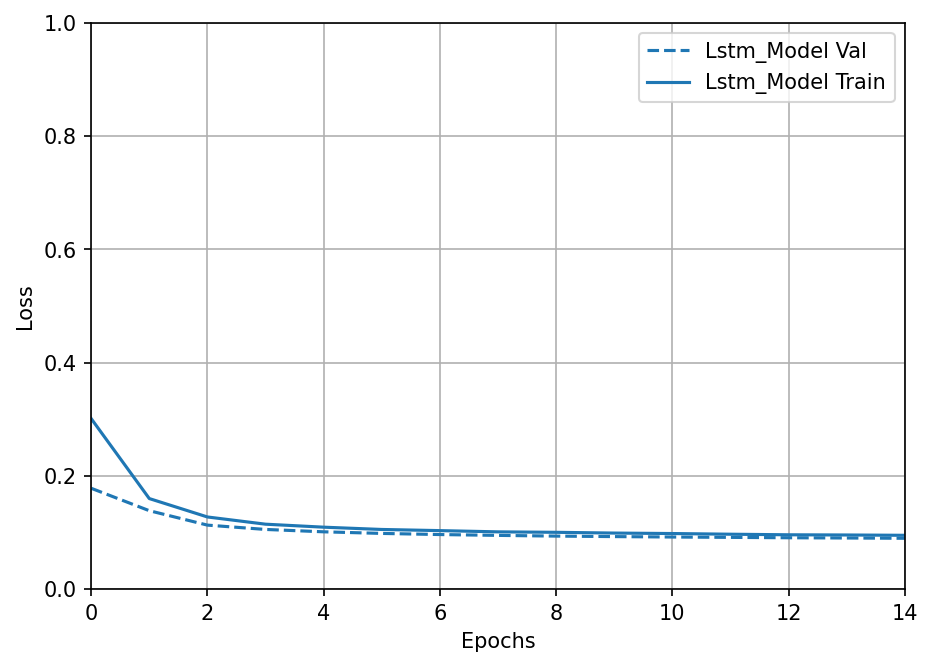

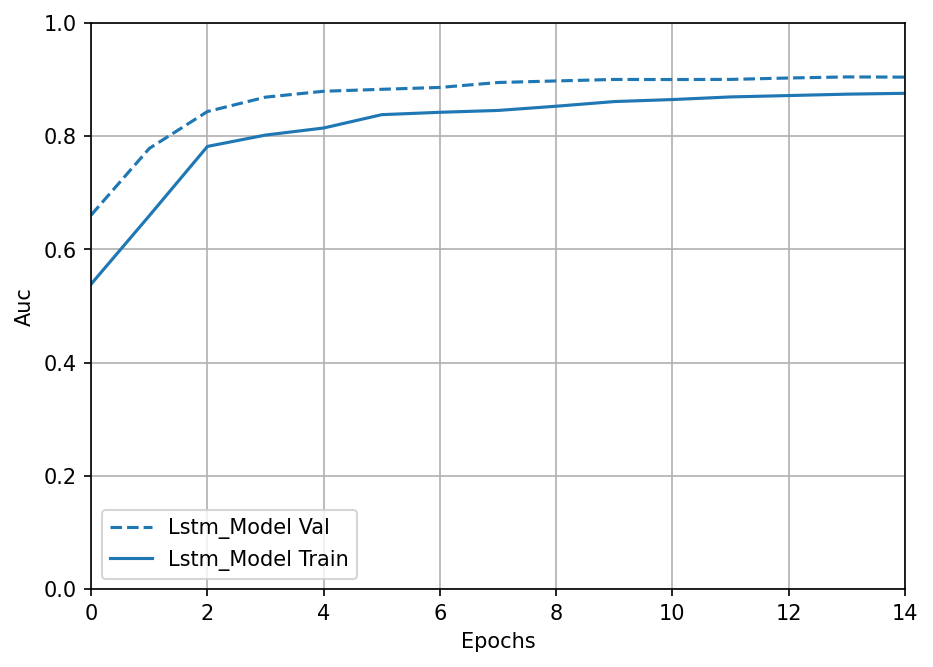

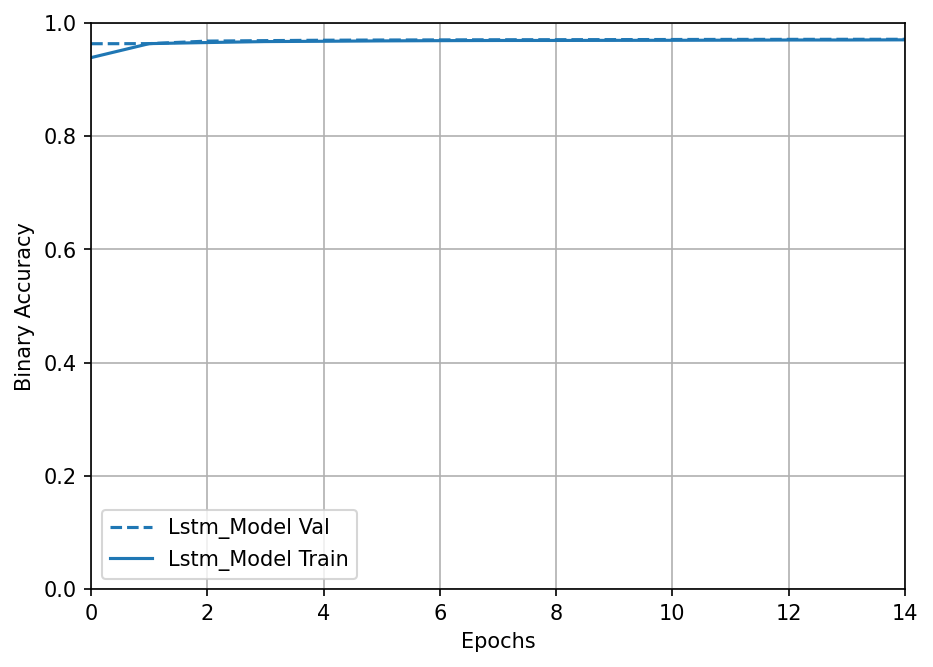

In [74]:
plot_history_models([('LSTM_Model', lstm_history)], key='loss', ylim=[0,1.0])
plot_history_models([('LSTM_Model', lstm_history)], key='auc', ylim=[0,1.0])
plot_history_models([('LSTM_Model', lstm_history)], key='binary_accuracy', ylim=[0, 1.0])

We can say from graphs our model has converged fairly 

In [75]:
def compute_classwise_metrics(model, X, y, conf_th=0.5, name='Validation'):
    """
    Computes class-wise metrics for a given model's predictions.
    
    Args:
        model: Trained model to compute predictions.
        X: Input data for predictions.
        y: True labels for the data.
        conf_th: Confidence threshold for binary predictions (default: 0.5).
        name: Name of the dataset (default: 'Validation').
    """
    predictions = model.predict(X)
    
    print("{} - Metrics computation @ conf_th = {}\n".format(name, conf_th))
    
    for idx, cls_ in enumerate(target_columns):
        cls_prob = predictions[:, idx]
        pred = [1 if prob >= conf_th else 0 for prob in cls_prob]
        gt = y[cls_]
    
        print('{} accuracy for {} is {}'.format(name, cls_, accuracy_score(gt, pred)))


In [76]:
compute_classwise_metrics(lstm_model, X_valid, y_valid)

998/998 [==============================] - 9s 9ms/step
Validation - Metrics computation @ conf_th = 0.5

Validation accuracy for toxic is 0.9302835657214475
Validation accuracy for severe_toxic is 0.9900673664421119
Validation accuracy for obscene is 0.9582014726617578
Validation accuracy for threat is 0.9976500078333073
Validation accuracy for insult is 0.9586401378662072
Validation accuracy for identity_hate is 0.9908193639354536


Due to computation constraint we only trained the model for 15 epochs. 

In [77]:
# Test related evaluation
y_test = test_data[target_columns]
compute_classwise_metrics(lstm_model, X_test, y_test, name='Test')

2000/2000 [==============================] - 17s 9ms/step
Test - Metrics computation @ conf_th = 0.5

Test accuracy for toxic is 0.9128294101097252
Test accuracy for severe_toxic is 0.9941073494013567
Test accuracy for obscene is 0.9464503423051674
Test accuracy for threat is 0.9966863609365719
Test accuracy for insult is 0.9486229641439244
Test accuracy for identity_hate is 0.9887773922285785


Comparing this test set result with the result of **Method-3** from **Task-1**, we notice they are almost very similar. Overally LSTM model achiever slightly better accuracy. 

Following are reasons to choose a Neural Network (NN) model like LSTM over traditional ML approach

- We used neural network, since we have fairly large amount of data available in this corpus. Neural networks can easily overfit if we have small amount of data. 
- LSTM can better model the relationships between words in given input sequence, hence offering a better contextual understanding. 
- Also, in general in traditional ML approach requires heavy manual feature engineering, which can be avoided using NN